In [1]:
from utils import DeepWalk

import networkx as nx
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from matplotlib import pyplot as plt
from tqdm import tqdm

### Vanilla DeepWalk on Karate Club graph to test the plausibility of DeepWalk implementation 

In [2]:
G = nx.karate_club_graph()

In [3]:
model = DeepWalk(G, 
                 20, 
                 8, 
                 100, 
                 10, 
                 0.025, 
                 False, 
                 None, 
                 None, 
                 None)

In [4]:
model.train()

In [5]:
X1 = model.Phi 

In [6]:
club_colors = {
    'Mr. Hi': 'green',
    'Officer': 'red'
}

node_colors = [club_colors[G.nodes[node]['club']] for node in G.nodes]

pos = nx.spring_layout(G)  

pca = PCA(n_components=2)
principal_components = pca.fit_transform(model.Phi)

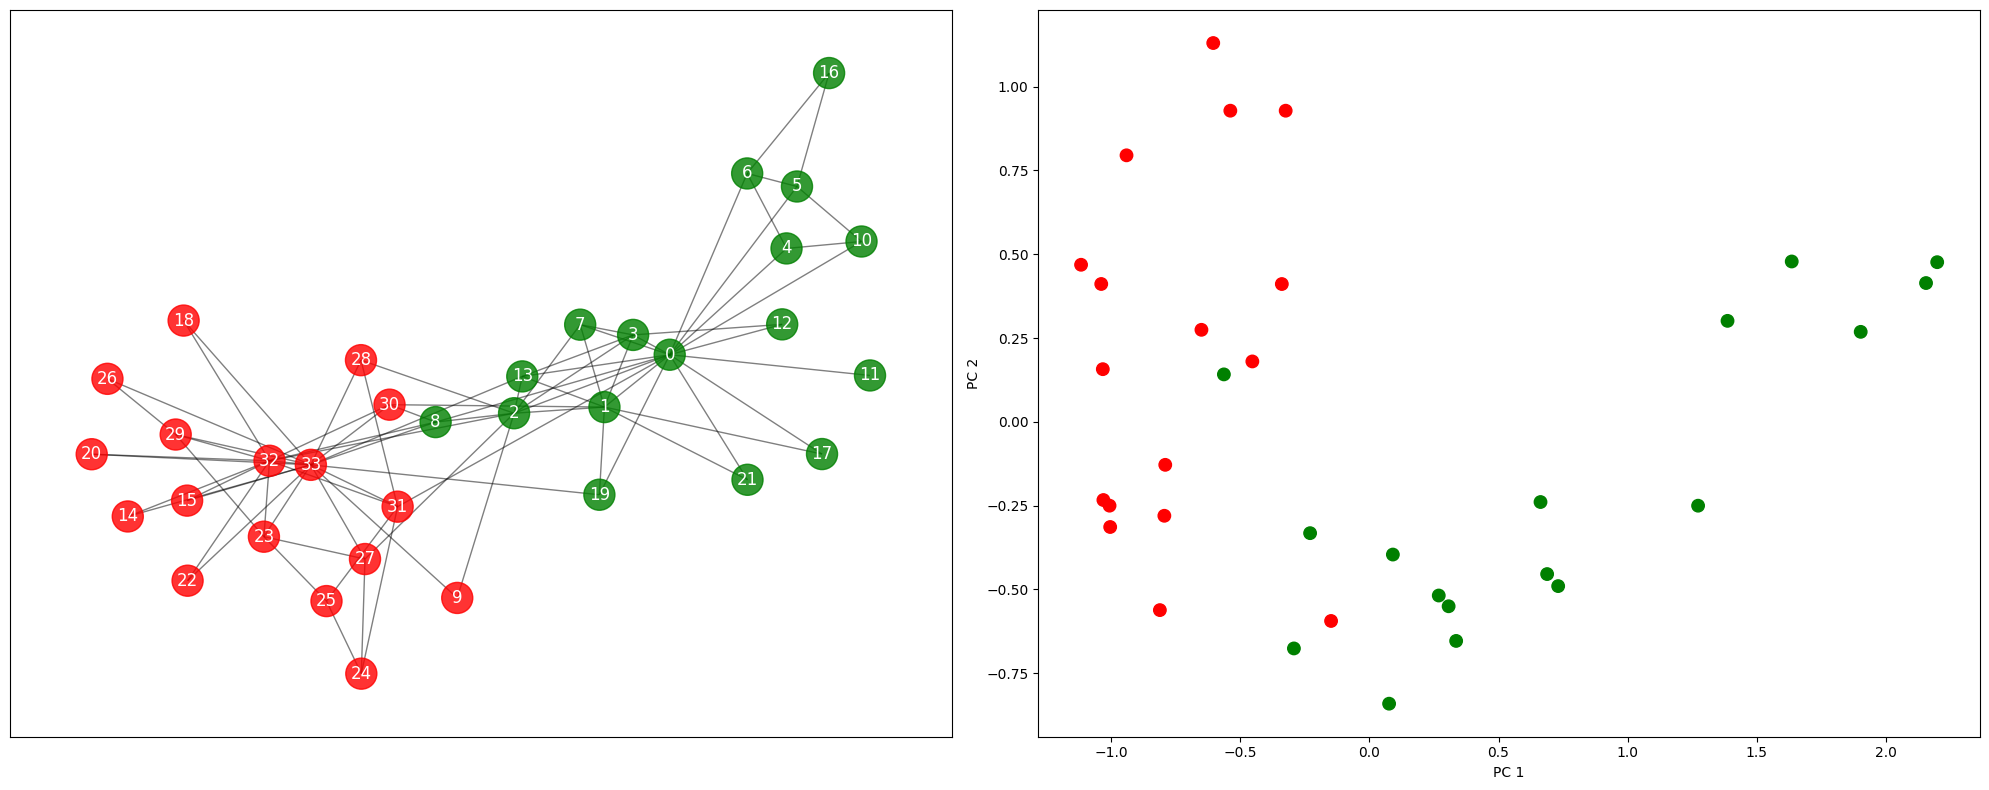

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8, ax=axes[0])
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=axes[0])
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white', ax=axes[0])

axes[1].scatter(principal_components[:,0], 
                principal_components[:,1],
                s=80, 
                color=node_colors)

axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')

plt.tight_layout()
plt.show()

_______________________

## Generating synthetic node signals dataset over karate club graph 

In [8]:
G = nx.karate_club_graph()

In [9]:
classes = [G.nodes[node]['club'] for node in G.nodes]

In [28]:
N = len(classes)
D = 2 
C = 2 

M = 200

In [29]:
# Generating data from different normal distribution for the different classes

nodes_data = np.zeros((N*D, M))

distros = {
    label: {
        'mu': np.random.normal(0, 5, D),
        'var': np.eye(D)
    }
    for label in set(classes)
}

labels = {
    0: 'Mr. Hi',
    1: 'Officer'
}

In [30]:
for node in tqdm(range(N)):
    i = classes[node]
    classes[node] = i
    mu = distros[i]['mu']
    var = distros[i]['var']

    nodes_data[node*D:(node+1)*D,:] = (np.random.multivariate_normal(mean = mu, cov = var, size = M) +                               # True signal
                                       np.random.multivariate_normal(mean = np.zeros(D),  cov = 0.01*np.eye(D), size = M)).T         # Noise

100%|██████████| 34/34 [00:00<00:00, 3779.35it/s]


In [31]:
edges_array = np.zeros((2, len(G.edges)), dtype='int32')

In [32]:
for i, edge in enumerate(list(G.edges)):
    edges_array[0,i] = edge[0]
    edges_array[1,i] = edge[1]

In [33]:
nodes = np.arange(N)

In [34]:
from utils import GraphSheaf

In [35]:
model = DeepWalk(G, 
                 20, 
                 8, 
                 100, 
                 10, 
                 0.025, 
                 True, 
                 nodes_data, 
                 D, 
                 10)

In [36]:
model.Sheaf.builder()

100%|██████████| 78/78 [00:00<00:00, 4875.14it/s]


In [37]:
model.train()

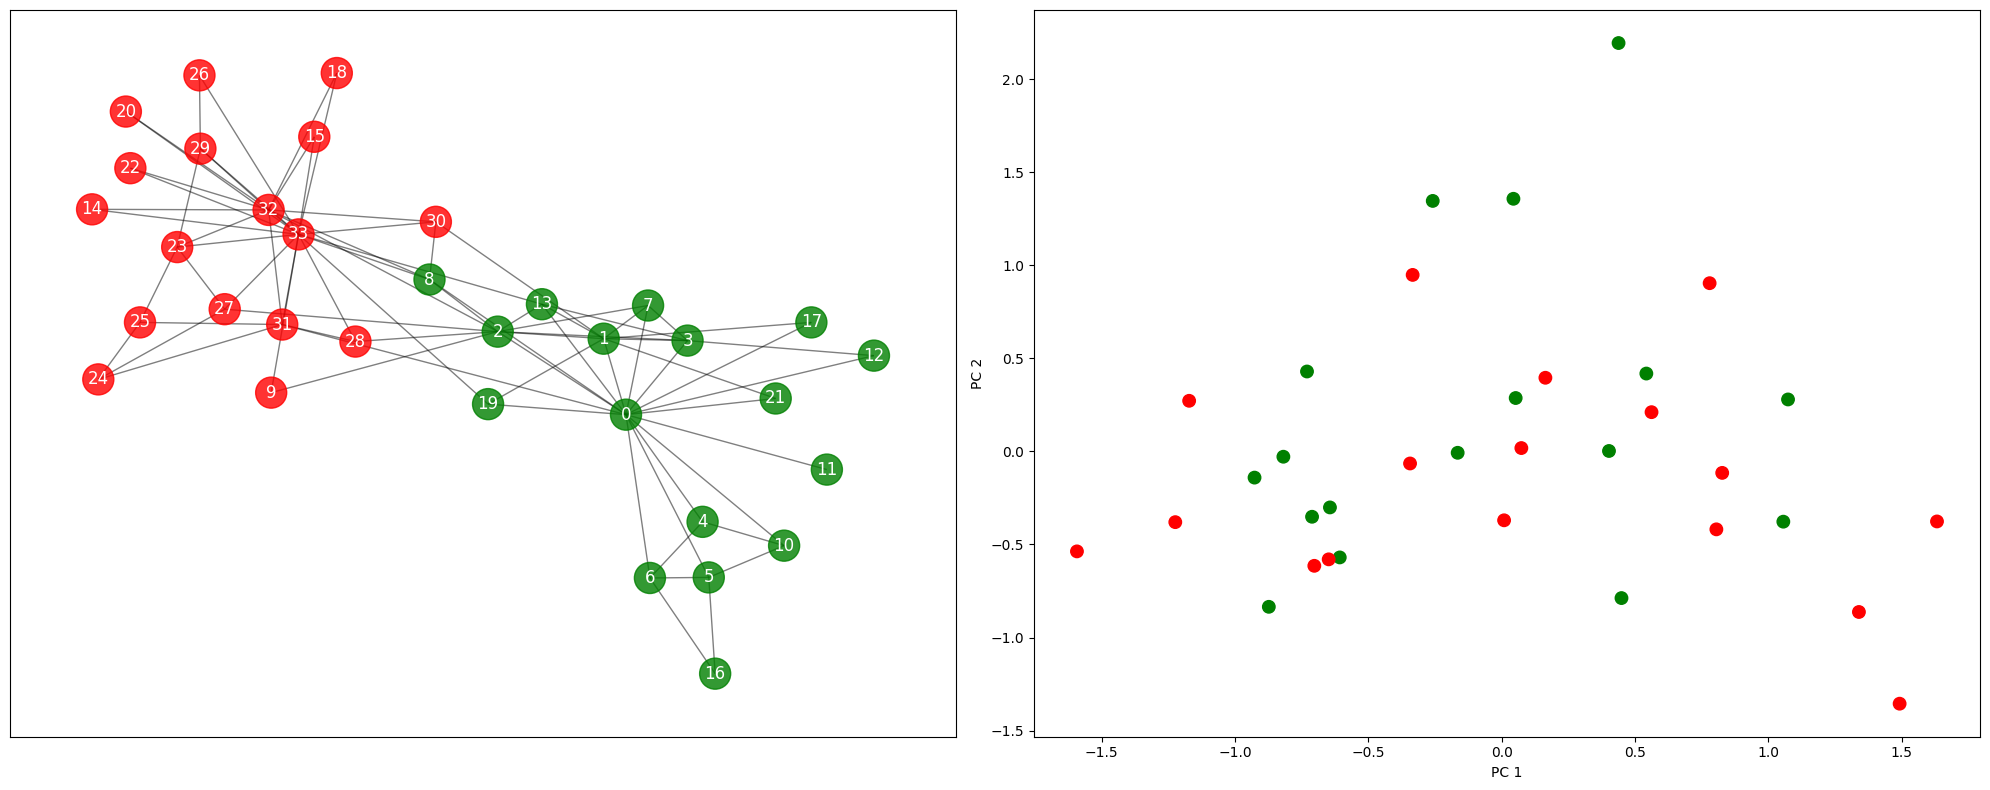

In [38]:
club_colors = {
    'Mr. Hi': 'green',
    'Officer': 'red'
}

node_colors = [club_colors[G.nodes[node]['club']] for node in G.nodes]

pos = nx.spring_layout(G)  

pca = PCA(n_components=3)
principal_components = pca.fit_transform(model.Phi)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8, ax=axes[0])
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=axes[0])
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white', ax=axes[0])

axes[1].scatter(principal_components[:,0], 
                principal_components[:,1],
                s=80, 
                color=node_colors)

axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')

plt.tight_layout()
plt.show()

In [39]:
X2 = model.Phi

### A first test

In [40]:
classes_ = np.zeros(34, dtype='int32')
for i in range(len(classes)):
    if classes[i] == 'Mr. Hi':
        classes_[i] = 1 

In [41]:
classes_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Standardize the features
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, classes_, test_size=0.2, random_state=42)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the classifier
classifier = LogisticRegression()

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.8571
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.67      0.80         3

    accuracy                           0.86         7
   macro avg       0.90      0.83      0.84         7
weighted avg       0.89      0.86      0.85         7

Confusion Matrix:
[[4 0]
 [1 2]]


In [44]:
# Standardize the features
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X2, classes_, test_size=0.2, random_state=42)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the classifier
classifier = LogisticRegression()

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.7143
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.60      1.00      0.75         3

    accuracy                           0.71         7
   macro avg       0.80      0.75      0.71         7
weighted avg       0.83      0.71      0.70         7

Confusion Matrix:
[[2 2]
 [0 3]]
